<a href="https://colab.research.google.com/github/JaafarBK02/CS122/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import seaborn as sbs


df = pd.read_csv('sample_data/social_media_posts.csv')
df.head()


,user_id,post_id,post_content,likes,shares,post_date
0,1001,1,Loving the new iPhone! #Apple #Tech https://ap...,120.0,50.0,2024-02-20
1,1002,2,NaN,95.0,30.0,2024-02-19
2,1003,3,Check out my new sneakers! #Nike #style 👟,NaN,75.0,2024-02-18
3,1004,4,Can’t wait to travel again! ✈️ #wanderlust #tr...,180.0,65.0,2024-02-17
4,1005,5,What a disaster... didn’t work at all! 😞 #fail,50.0,20.0,2024-02-16


### Data Wrangling/munging

In [6]:
# Let's start by handling missing values.
print("----- Missing values count -----")
print(df.isnull().sum())

#likes
median_likes= df['likes'].median()
df['likes'] = df['likes'].fillna(median_likes)
print(f"\nFilled 'likes' with median value: {median_likes}")

#shares
mean_shares=df['shares'].mean()
df['shares'] = df['shares'].fillna(mean_shares)
print(f"Filled 'shares' with mean value: {round(mean_shares)}")

#post_content
df['post_content']= df['post_content'].fillna('No Text')
print("Filled 'post_content' with 'No Text'")





----- Missing values count -----
user_id          0
post_id          0
post_content     5
likes           10
shares           6
post_date        0
dtype: int64

Filled 'likes' with median value: 210.0
Filled 'shares' with mean value: 87
Filled 'post_content' with 'No Text'


In [7]:
# Let's clean post_content
import re

#helpers
URL_RE = re.compile(r'https?://\S+|www\.\S+')
TAG_RE = re.compile(r'[#@][A-Za-z0-9_]+')
EMO_RE = re.compile(r'[\U00010000-\U0010ffff]')
PUNC_RE = re.compile(r'[^\w\s]')



# functions
def clean_post_content(text):
 """: Cleans the text by removing URLs, mentions, hashtags,punctuation, emojis, and extra spaces. Returns a plain string containing only the cleaned text."""
 text = str(text)
 text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove URLs
 text = re.sub(r'[@#][A-Za-z0-9_]+', '', text)  # remove # and @
 text = re.sub(r'[\U00010000-\U0010ffff]', '', text) # remove emojis
 text = re.sub(r'[^\w\s]', '', text)  # remove punctuation

 return text


df['clean_post_content'] = df['post_content'].apply(clean_post_content)





In [58]:
# Lastly, we will Convert post_date to datetime format and extract hashtags and store them in a new column Hashtags

df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce')

def extract_hashtags(text):
  return re.findall(r'#\w+', str(text))

df['Hashtags'] = df['post_content'].apply(extract_hashtags)
df



,user_id,post_id,post_content,likes,shares,post_date,clean_post_content,Hashtags
0,1001,1,Loving the new iPhone! #Apple #Tech https://ap...,120.0,50.0,2024-02-20,Loving the new iPhone,"[#Apple, #Tech]"
1,1002,2,No Text,95.0,30.0,2024-02-19,No Text,[]
2,1003,3,Check out my new sneakers! #Nike #style 👟,210.0,75.0,2024-02-18,Check out my new sneakers,"[#Nike, #style]"
3,1004,4,Can’t wait to travel again! ✈️ #wanderlust #tr...,180.0,65.0,2024-02-17,Cant wait to travel again,"[#wanderlust, #travel]"
4,1005,5,What a disaster... didn’t work at all! 😞 #fail,50.0,20.0,2024-02-16,What a disaster didnt work at all,[#fail]
...,...,...,...,...,...,...,...,...
495,1116,496,Went to the beach with @seasidelovers 🏖️ #beac...,250.0,120.0,2022-10-13,Went to the beach with,"[#beachfun, #sunshine]"
496,1117,497,Had an awesome brunch with @weekend_brunchers ...,220.0,100.0,2022-10-12,Had an awesome brunch with,"[#brunchvibes, #foodie]"
497,1118,498,Spent the day at the park with @outdoor_explor...,210.0,95.0,2022-10-11,Spent the day at the park with,"[#naturelover, #familyfun]"
498,1119,499,Went for a scenic drive with @roadtrip_fan 🚗 #...,230.0,105.0,2022-10-10,Went for a scenic drive with,"[#roadtrip, #adventure]"


### Data Analysis

In [57]:
#Identify the Top 3 users by total engagement (average likes + average shares).
def get_avg_engagement(df):
  user_engagement= df.groupby('user_id')[['likes','shares']].mean().reset_index()
  user_engagement['total_engagment'] = user_engagement['likes']+ user_engagement['shares']
  user_engagement.rename(columns={'likes': 'avg_likes', 'shares': 'avg_shares'}, inplace=True)
  top3_users= user_engagement.sort_values('total_engagment', ascending=False).head(3)
  return top3_users


get_avg_engagement(df)



,user_id,avg_likes,avg_shares,total_engagment
23,1024,250.0,120.0,370.0
36,1037,250.0,120.0,370.0
46,1047,250.0,120.0,370.0


In [77]:
#Determine the Top 5 hashtags based on frequency of appearance.
hashtags_serie= df['Hashtags'].explode()
hashtags_serie= hashtags_serie.dropna()
top5_hashttags= hashtags_serie.value_counts().head(5)

print("Top 5 hashtags by frequency of appearance: ")
print(f"\n")
print(top5_hashttags)

Top 5 hashtags by frequency of appearance: 


Hashtags
#outdoorfun    27
#foodie        26
#cozytime      20
#adventure     20
#goodtimes     20
Name: count, dtype: int64


###Sentiment Analysis

In [120]:
from textblob import TextBlob


def get_sentiment(text):
  return TextBlob(str(text)).sentiment.polarity

df['polarity']= df['post_content'].apply(get_sentiment)

def label_sentiment(p):
  if p>0: return 'positive'
  elif p<0: return 'negative'
  else: return 'neutral'

df['sentiment']= df['polarity'].apply(label_sentiment)

print(' overall sentiment distribution:', df['sentiment'].value_counts())

avg_sentiment= df.groupby('user_id')['polarity'].mean()
print(f'\n')
print(avg_sentiment)




 overall sentiment distribution: sentiment
positive    334
neutral      97
negative     69
Name: count, dtype: int64


user_id
1001    0.369253
1002    0.231697
1003    0.294621
1004    0.427089
1005    0.307570
          ...   
1116    0.000000
1117    1.000000
1118   -0.100000
1119    0.000000
1120    0.300000
Name: polarity, Length: 120, dtype: float64


### Visualization

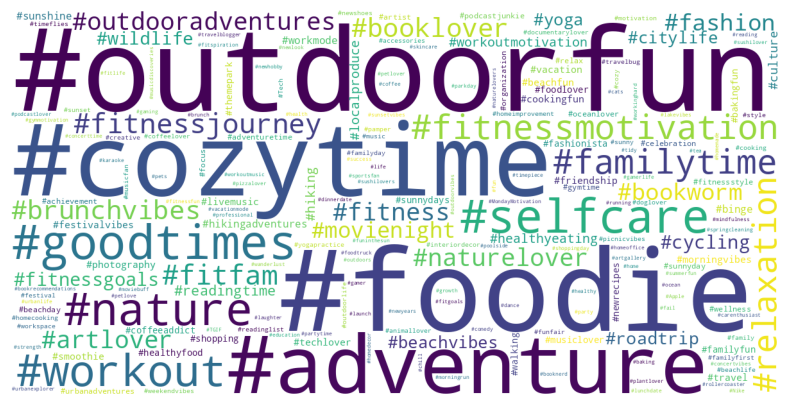

In [95]:
# Word Cloud of hashtags

from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

freqs = hashtags_serie.value_counts().to_dict()
wc = WordCloud(width=1200, height=600, background_color='white')
wc = wc.generate_from_frequencies(freqs)
plt.figure(figsize=(10, 5))
plt.imshow(wc)
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()




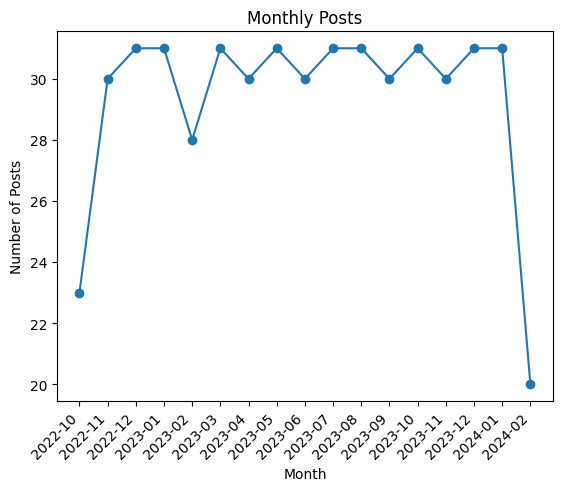

In [112]:
# Monthly Posts (line plot)
monthly_posts = df['post_date'].dt.to_period('M').value_counts().sort_index()

plt.plot(monthly_posts.index.astype(str), monthly_posts.values, marker='o')
plt.title('Monthly Posts')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.savefig('monthly_posts.png')

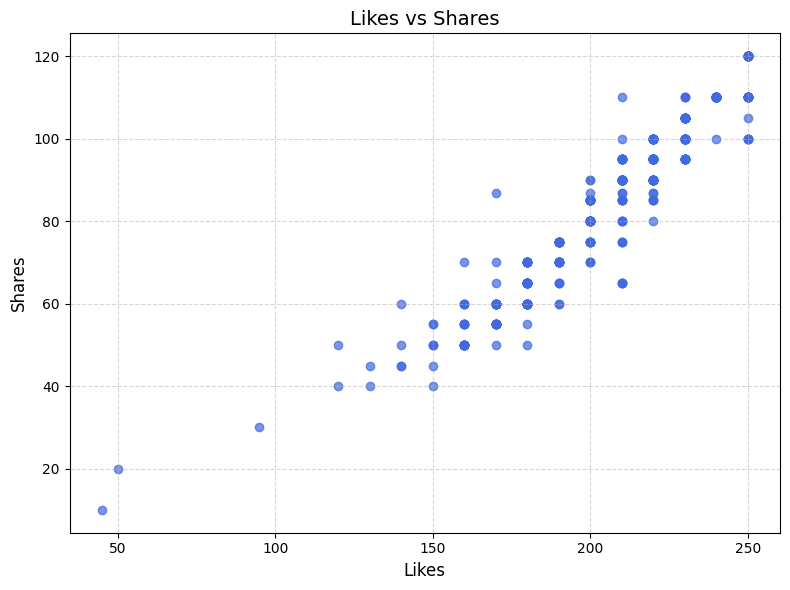

<Figure size 640x480 with 0 Axes>

In [110]:
#Likes vs Shares (scatter plot)
plt.figure(figsize=(8,6))
plt.scatter(df['likes'], df['shares'], color='royalblue', alpha=0.7)
plt.title('Likes vs Shares', fontsize=14)
plt.xlabel('Likes', fontsize=12)
plt.ylabel('Shares', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()
plt.savefig('likes_vs_shares.png')

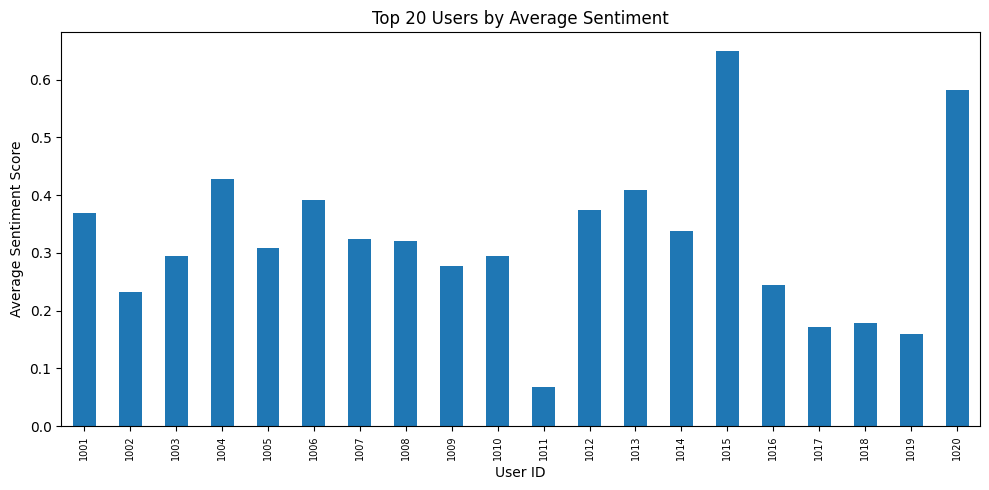

In [126]:
plt.figure(figsize=(12,5))
#plt.bar(avg_sentiment.index.astype(str), avg_sentiment.values, color='skyblue')
avg_sentiment.head(20).plot(kind='bar', figsize=(10,5)) # to make it readable
#plt.title('Average Sentiment per User')
plt.title('Top 20 Users by Average Sentiment')
plt.xlabel('User ID')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig('avg_sentiment_per_user.png', dpi=200)
plt.show()